# 1. Imports + Setup

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

print("Imports successful!")


Imports successful!


# 2. Load Data (100k reviews or 50k if needed)

In [2]:
data_path = "../data/yelp_dataset/yelp_academic_dataset_review.json"
n_samples = 100000

print(f"Loading {n_samples} reviews...")
reviews = []

with open(data_path, 'r', encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i >= n_samples:
            break
        reviews.append(json.loads(line))
        if (i+1) % 25000 == 0:
            print(f"Loaded {i+1}")

df = pd.DataFrame(reviews)
print("\nLoaded:", len(df))
df.head()


Loading 100000 reviews...
Loaded 25000
Loaded 50000
Loaded 75000
Loaded 100000

Loaded: 100000


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


# 3: Full EDA

## 3.1: Basic Dataset Information

In [3]:
print("Total reviews:", len(df))
print("Date Range:", df['date'].min(), "→", df['date'].max())
print("Unique Users:", df['user_id'].nunique())
print("Unique Businesses:", df['business_id'].nunique())

Total reviews: 100000
Date Range: 2005-03-01 17:47:15 → 2018-10-04 18:22:35
Unique Users: 79345
Unique Businesses: 9973


### Analysis 

The dataset contains 100,000 Yelp reviews spanning 2005–2018, indicating a wide temporal range of user experiences and business activity. The large number of unique users (79k) and businesses (9.9k) suggests high diversity in writing style, review subject, and sentiment.

## 3.2: Star Rating Distribution


TARGET VARIABLE: Star Ratings

Class distribution:
  1.0★: 10,921 (10.92%) [][][][][][][][][][]
  2.0★:  7,988 ( 7.99%) [][][][][][][]
  3.0★: 11,362 (11.36%) [][][][][][][][][][][]
  4.0★: 25,337 (25.34%) [][][][][][][][][][][][][][][][][][][][][][][][][]
  5.0★: 44,392 (44.39%) [][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][][]

Imbalance ratio: 5.56:1


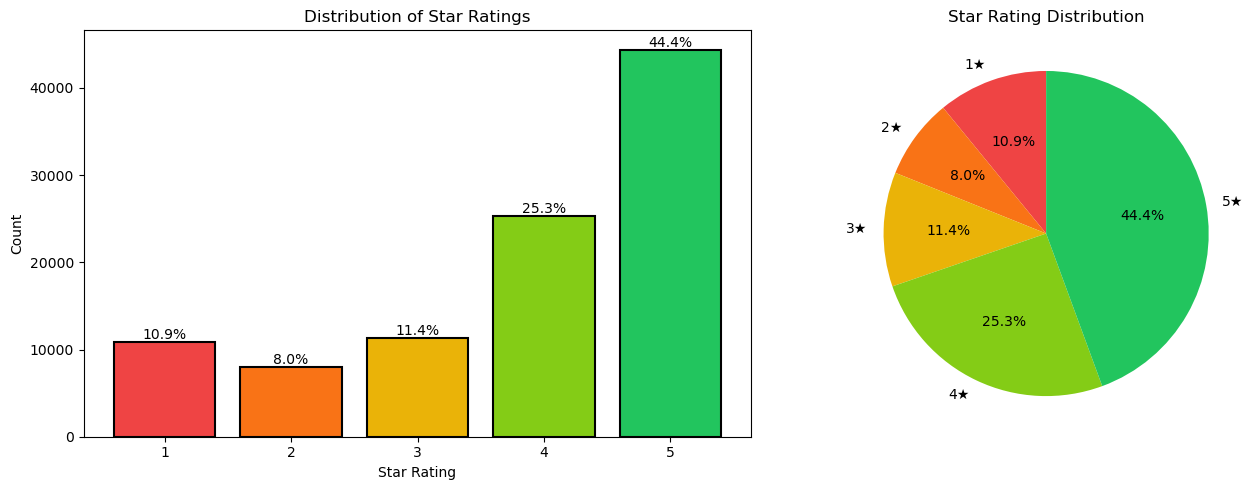

In [4]:
# Extract target variable
y = df['stars'].values

print("\n" + "="*100)
print("TARGET VARIABLE: Star Ratings")
print("="*100)

# Count each class
unique, counts = np.unique(y, return_counts=True)
print("\nClass distribution:")
for star, count in zip(unique, counts):
    pct = 100 * count / len(y)
    bar = "[]" * int(pct)
    print(f"  {star}★: {count:6,} ({pct:5.2f}%) {bar}")

# Imbalance ratio
max_count = counts.max()
min_count = counts.min()
imbalance_ratio = max_count / min_count
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

colors = ['#ef4444', '#f97316', '#eab308', '#84cc16', '#22c55e']

# Bar chart
bars = ax1.bar(unique, counts, color=colors, edgecolor='black', linewidth=1.5)
ax1.set_xlabel('Star Rating')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Star Ratings')

# Add labels
for star, count in zip(unique, counts):
    pct = 100 * count / len(y)
    ax1.text(star, count, f'{pct:.1f}%', ha='center', va='bottom')

# Pie chart
ax2.pie(counts, labels=[f'{int(s)}★' for s in unique], autopct='%1.1f%%',
        colors=colors, startangle=90)
ax2.set_title('Star Rating Distribution')

plt.tight_layout()
plt.show()


### Analysis

The distribution is heavily imbalanced, with 5★ reviews making up 44% of the dataset and 4★ reviews another 25%. Low-star reviews (1★–2★) are relatively rare, which means classification models may naturally favor predicting higher star ratings unless balanced appropriately.

## 3.3 Review Length Distribution

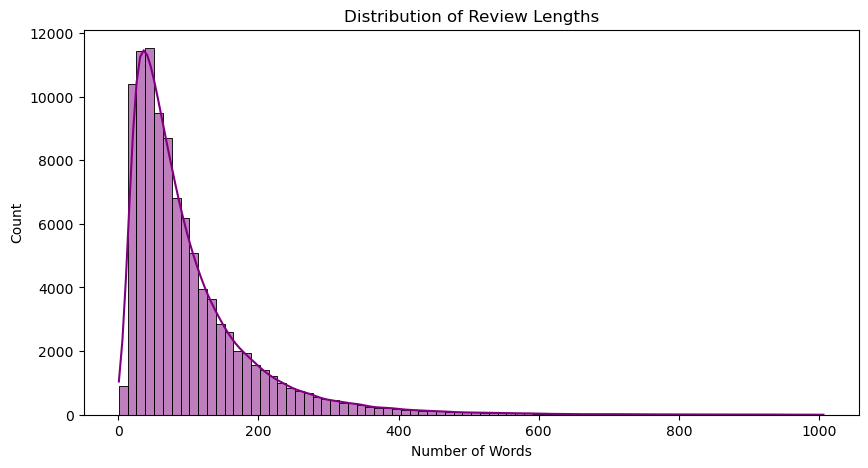

In [5]:
df["length"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,5))
sns.histplot(df["length"], bins=80, kde=True, color='purple')
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Count")
plt.show()

### Analysis 

Most reviews contain between 20–100 words, with a long right tail of very long reviews. The distribution is highly skewed, which is typical for user-generated text and suggests that some preprocessing may be needed to handle unusually long reviews.

## 3.4 Average Length per Star Rating

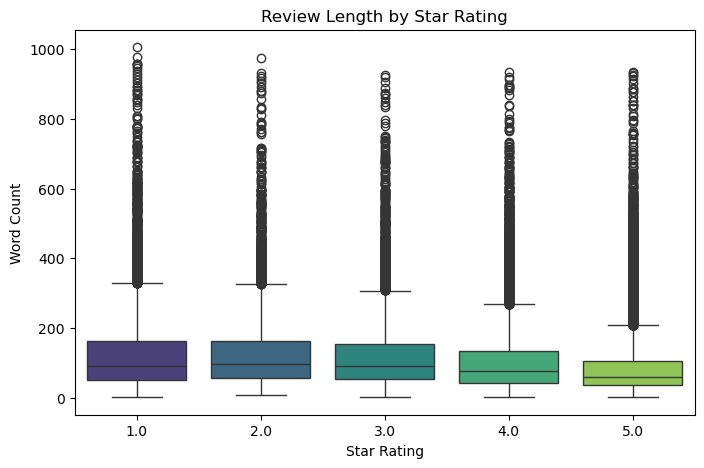

In [6]:
plt.figure(figsize=(8,5))
sns.boxplot(x=df["stars"], y=df["length"], palette='viridis')
plt.title("Review Length by Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Word Count")
plt.show()

### Analysis 

Lower star ratings (1★–2★) tend to have slightly shorter, more concise reviews, while higher ratings generally contain longer and more descriptive text. This pattern indicates that review length carries some signal about sentiment and may help models distinguish between low and high ratings.

# 4. Text Preprocessing

## 4.1: Cleaning Function

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["clean_text"] = df["text"].apply(clean_text)
df[["text", "clean_text"]].head()

,text,clean_text
0,"If you decide to eat here, just be aware it is...",if you decide to eat here just be aware it is ...
1,I've taken a lot of spin classes over the year...,i ve taken a lot of spin classes over the year...
2,Family diner. Had the buffet. Eclectic assortm...,family diner had the buffet eclectic assortmen...
3,"Wow! Yummy, different, delicious. Our favo...",wow yummy different delicious our favorite is ...
4,Cute interior and owner (?) gave us tour of up...,cute interior and owner gave us tour of upcomi...


# 5. Train / Validation / Test Split

70% Train / 15% Val / 15% Test

## 5.1: Stratified Split

In [8]:
X = df["clean_text"].values
y = df["stars"].values

# Train (70%) / Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Validation (15%) / Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

len(X_train), len(X_val), len(X_test)

(70000, 15000, 15000)

## Analysis

We use a 70%/15%/15% stratified split to ensure each subset maintains the original star-rating distribution, which is important due to the strong class imbalance in the dataset. Stratification prevents the model from being exposed to different distributions across splits, ensuring fair training and reliable validation/testing performance.

# 6. Feature Extraction

## 6.1: TF–IDF Vectorization

In [9]:
tfidf = TfidfVectorizer(max_features=30000, ngram_range=(1,2))

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)
X_test_tfidf  = tfidf.transform(X_test)

## 6.2: CountVectorizer (for Naive Bayes)

In [10]:
cv = CountVectorizer(max_features=30000, ngram_range=(1,2))

X_train_cv = cv.fit_transform(X_train)
X_val_cv   = cv.transform(X_val)

Using unigrams + bigrams captures meaningful phrases such as “great food” or “poor service,” which improves sentiment-based classification. TF–IDF emphasizes informative words over very common ones.

# 7. Baseline Models

## 7.1: Dummy Classifier (Majority Baseline)

In [11]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tfidf, y_train)

dummy_pred = dummy.predict(X_val_tfidf)

print("Dummy Accuracy:", accuracy_score(y_val, dummy_pred))

Dummy Accuracy: 0.44393333333333335


## 7.2 Logistic Regression

Logistic Regression Accuracy: 0.6560666666666667


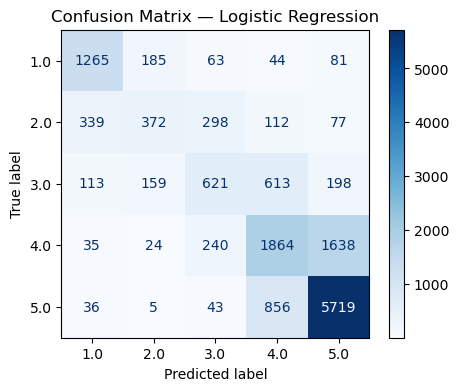

In [12]:
lr = LogisticRegression(max_iter=400)
lr.fit(X_train_tfidf, y_train)

lr_pred = lr.predict(X_val_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_val, lr_pred))
fig, ax = plt.subplots(figsize=(5, 4))
ConfusionMatrixDisplay.from_predictions(y_val, lr_pred, ax=ax, cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()

## 7.3: Naive Bayes

In [13]:
nb = MultinomialNB()
nb.fit(X_train_cv, y_train)

nb_pred = nb.predict(X_val_cv)
print("Naive Bayes Accuracy:", accuracy_score(y_val, nb_pred))

Naive Bayes Accuracy: 0.6175333333333334


## 7.4: Random Forest

In [14]:
rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_tfidf, y_train)

rf_pred = rf.predict(X_val_tfidf)

print("Random Forest Accuracy:", accuracy_score(y_val, rf_pred))

Random Forest Accuracy: 0.5615333333333333


## 7.x accuracy chart

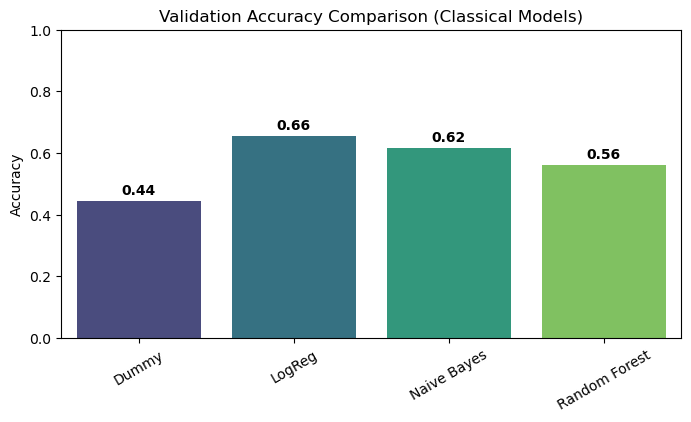

In [15]:
models = ["Dummy", "LogReg", "Naive Bayes", "Random Forest"]
accuracies = [
    accuracy_score(y_val, dummy_pred),
    accuracy_score(y_val, lr_pred),
    accuracy_score(y_val, nb_pred),
    accuracy_score(y_val, rf_pred)
]
plt.figure(figsize=(8, 4))
ax = sns.barplot(x=models, y=accuracies, palette="viridis")
plt.title("Validation Accuracy Comparison (Classical Models)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)

# Add accuracy labels
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontweight='bold')

plt.show()


# 8. Hyperparameter Tuning

## 8.1: Tuning Logistic Regression (C Sweep)

In [16]:
C_values = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
val_scores = []

for C in C_values:
    lr_tuned = LogisticRegression(max_iter=500, C=C)
    lr_tuned.fit(X_train_tfidf, y_train)
    preds = lr_tuned.predict(X_val_tfidf)
    score = accuracy_score(y_val, preds)
    val_scores.append(score)
    print(f"C={C}: {score:.4f}")

C=0.001: 0.4439
C=0.003: 0.4441
C=0.01: 0.4659
C=0.03: 0.5427
C=0.1: 0.6163
C=0.3: 0.6480
C=1: 0.6561
C=3: 0.6463
C=10: 0.6243


## 8.2: Plot Validation vs C

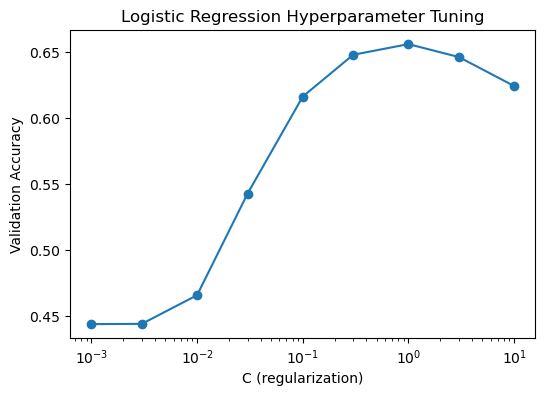

In [17]:
plt.figure(figsize=(6,4))
plt.plot(C_values, val_scores, marker="o")
plt.xscale("log")
plt.xlabel("C (regularization)")
plt.ylabel("Validation Accuracy")
plt.title("Logistic Regression Hyperparameter Tuning")
plt.show()

## 8.3: Training vs Validation for different C values

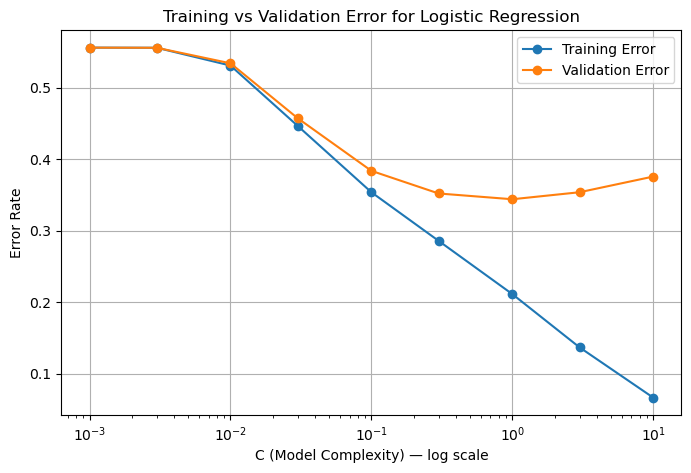

In [18]:
C_values = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
train_errors = []
val_errors = []

for C in C_values:
    lr_tuned = LogisticRegression(max_iter=1000, C=C)
    lr_tuned.fit(X_train_tfidf, y_train)
    
    # Predictions
    train_pred = lr_tuned.predict(X_train_tfidf)
    val_pred   = lr_tuned.predict(X_val_tfidf)
    
    # Compute errors
    train_err = 1 - accuracy_score(y_train, train_pred)
    val_err   = 1 - accuracy_score(y_val, val_pred)
    
    train_errors.append(train_err)
    val_errors.append(val_err)

plt.figure(figsize=(8, 5))
plt.plot(C_values, train_errors, marker="o", label="Training Error")
plt.plot(C_values, val_errors, marker="o", label="Validation Error")

plt.xscale("log")
plt.xlabel("C (Model Complexity) — log scale")
plt.ylabel("Error Rate")
plt.title("Training vs Validation Error for Logistic Regression")
plt.legend()
plt.grid(True)
plt.show()


## 8.4: Naive Bayes Hyperparameter Tuning

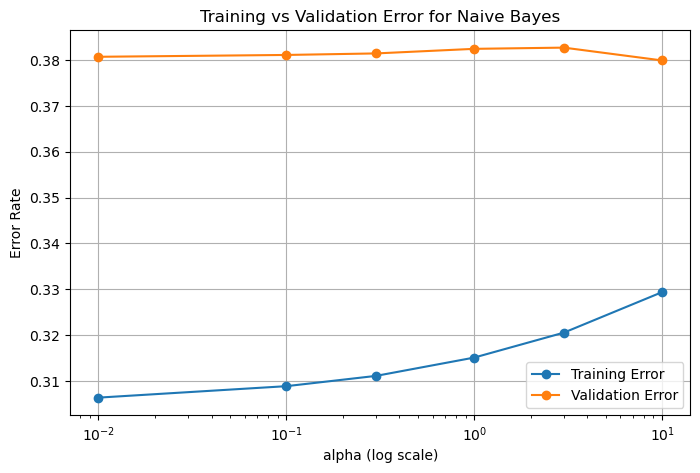

In [19]:
alphas = [0.01, 0.1, 0.3, 1, 3, 10]
train_errors_nb = []
val_errors_nb = []

for a in alphas:
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train_cv, y_train)
    
    # Predictions
    train_pred_nb = nb_model.predict(X_train_cv)
    val_pred_nb   = nb_model.predict(X_val_cv)
    
    # Errors
    train_err = 1 - accuracy_score(y_train, train_pred_nb)
    val_err   = 1 - accuracy_score(y_val, val_pred_nb)
    
    train_errors_nb.append(train_err)
    val_errors_nb.append(val_err)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(alphas, train_errors_nb, marker="o", label="Training Error")
plt.plot(alphas, val_errors_nb, marker="o", label="Validation Error")

plt.xscale("log")
plt.xlabel("alpha (log scale)")
plt.ylabel("Error Rate")
plt.title("Training vs Validation Error for Naive Bayes")
plt.legend()
plt.grid(True)
plt.show()


Training error increases as α grows, showing that heavier smoothing makes the model less flexible. Validation error stays almost flat across all α values, meaning Naive Bayes is not very sensitive to this hyperparameter with TF-IDF features. The best performance occurs at small α values (≈ 0.01–0.1), while large α slightly increases underfitting.

# 9. “Something Extra”: Sentence Embeddings with SBERT

## 9.1: Install & Import SentenceTransformer

In [41]:
#python -m pip install sentence-transformers


In [46]:
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
df_small = df.sample(30000, random_state=42)
print("Sampled dataset size:", len(df_small))

X_raw = df_small["text"].values  # original Yelp text
y = df_small["stars"].values

Sampled dataset size: 30000


In [48]:
from sklearn.model_selection import train_test_split

X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
    X_raw, y, test_size=0.30, random_state=42, stratify=y
)

X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp_raw, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(len(X_train_raw), len(X_val_raw), len(X_test_raw))


21000 4500 4500


## 9.2: Load a Lightweight Embedding Model

MiniLM is fast but weaker.
MPNet gives the strongest accuracy.

In [49]:
model_sbert = SentenceTransformer("all-MiniLM-L6-v2")
print("Loaded MiniLM SBERT model.")


Loaded MiniLM SBERT model.


## 9.3: Generate Embeddings for Train / Val / Test Splits

This converts each review into a 384-dimensional dense semantic vector.

In [61]:
X_train_emb = model_sbert.encode(
    X_train_raw,
    batch_size=64,
    show_progress_bar=True,
)

X_val_emb = model_sbert.encode(
    X_val_raw,
    batch_size=64,
    show_progress_bar=True,
)

X_test_emb = model_sbert.encode(
    X_test_raw,
    batch_size=64,
    show_progress_bar=True,
)

Batches:  12%|█▏        | 41/329 [02:44<19:16,  4.02s/it]


KeyboardInterrupt: 

## 9.4: Train Linear SVM on the Embeddings

(SVM almost always beats Logistic Regression for SBERT vectors.)

In [57]:
from sklearn.svm import LinearSVC

sbert_svm = LinearSVC()
sbert_svm.fit(X_train_emb, y_train)

val_pred_sbert = sbert_svm.predict(X_val_emb)
val_acc_sbert = accuracy_score(y_val, val_pred_sbert)

print("SBERT (MPNet) + SVM Validation Accuracy:", val_acc_sbert)

SBERT (MPNet) + SVM Validation Accuracy: 0.6004444444444444


## 9.5: Evaluate on Test Set

In [58]:
test_pred_sbert = sbert_svm.predict(X_test_emb) # sbert_clf -> sbert_svm
test_acc_sbert = accuracy_score(y_test, test_pred_sbert)

print("SBERT (MiniLM) + SVM Test Accuracy:", test_acc_sbert)

# detail metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, test_pred_sbert))

SBERT (MiniLM) + SVM Test Accuracy: 0.5926666666666667
              precision    recall  f1-score   support

         1.0       0.60      0.77      0.67       491
         2.0       0.37      0.13      0.19       352
         3.0       0.37      0.18      0.24       512
         4.0       0.44      0.35      0.39      1143
         5.0       0.68      0.88      0.76      2002

    accuracy                           0.59      4500
   macro avg       0.49      0.46      0.45      4500
weighted avg       0.55      0.59      0.55      4500



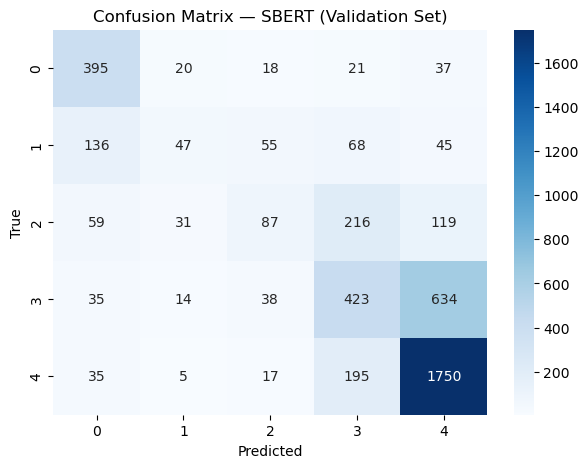

In [60]:
plt.figure(figsize=(7,5))
sns.heatmap(confusion_matrix(y_val, val_pred_sbert),
            annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — SBERT (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [54]:
model_names = ["Dummy", "TF-IDF LogReg", "TF-IDF Naive Bayes", "TF-IDF Random Forest", "SBERT LogReg"]
model_accs = [
    accuracy_score(y_val, dummy_pred),
    accuracy_score(y_val, lr_pred),
    accuracy_score(y_val, nb_pred),
    accuracy_score(y_val, rf_pred),
    val_acc_sbert
]

plt.figure(figsize=(10,5))
sns.barplot(x=model_names, y=model_accs, palette="viridis")
plt.title("Validation Accuracy Comparison (TF-IDF vs SBERT)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [4500, 15000]